In [1]:
import torch, os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from scipy.interpolate import interp1d
import random
from scipy import interpolate

### Get GT hyperspectral reflectance

Text(0.5, 0, 'wavelength [nm]')

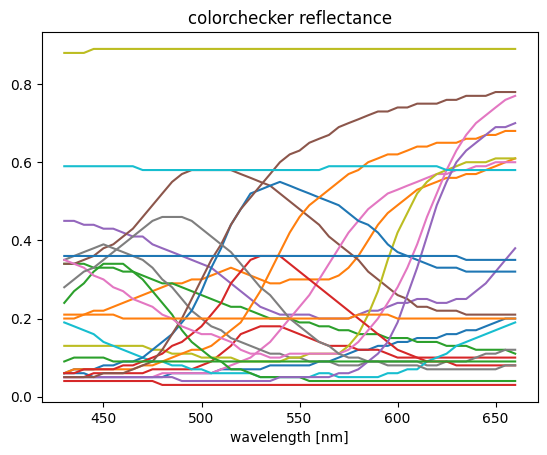

In [2]:
# Replace 'file.csv' with the path to your CSV file
file_path = '../../dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61

# 430nm - 660nm 5nm interval
wvls_CC = wvls_CC[ind_min:ind_max][4:-4]
ref_CC = ref_CC[ind_min:ind_max,:][4:-4]
ref_CC = ref_CC.astype(np.float16)

# print(wvls_CC, ref_CC)

plt.figure()
plt.plot(wvls_CC, ref_CC)
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [3]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

n_illum = 318
n_patches = 24
n_channel = 3

depth_start = 600
depth_end = 900     
depth_arange = np.arange(depth_start, depth_end + 1, 1)

patch_idx = np.arange(0, 24)
patch_size = 3

In [4]:
date = "1003"
real_data_dir = "../../dataset/data/2023%s_real_data/"%date

# center points for all patches 20231003
all_patches_center_pts = np.array([[200,160], [300,150], [418,142], [533,133],[651, 129], [770,100],
                                    [200,276], [308,267], [420,260], [537,251], [655,245], [780,237],
                                    [202,386], [310,382], [420,375], [540,375], [660,368], [780,360],
                                    [200,500], [300,490], [420,500], [540,500], [660,490], [790,480]])

### Projector & Camera Response function & Dg efficiency

In [5]:
# bring initial value of PEF and CRF
PEF = np.load('../../dataset/image_formation/CRF_proj.npy')
map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
PEF = map_scale(PEF).astype(np.float32)
PEF = PEF[3:27] # from 430nm

CRF = np.load('../../dataset/image_formation/CRF_230828.npy')[:,1:].T # from 430nm

DG_efficiency = np.load('../../dataset/image_formation/DG_update.npy') # from 430nm

#### Interpolation for 5nm interval

In [6]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

# wvls from 430 ~ 660 without 630nm
wvls = np.arange(430, 670, 10)
wvls = torch.tensor(wvls)*1e-9
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

In [7]:
# interpolated CRF for 5nm
CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 4)
CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 4)
CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 4)

# interpolated PEF for 5nm
PEF_R = cubic_interpolation(new_wvls, wvls, PEF[:,0], 4)
PEF_G = cubic_interpolation(new_wvls, wvls, PEF[:,1], 4)
PEF_B = cubic_interpolation(new_wvls, wvls, PEF[:,2], 4)

In [8]:
CRF_intp = np.stack((CRF_R, CRF_G, CRF_B))
PEF_intp = np.stack((PEF_R, PEF_G, PEF_B))

In [1]:
plt.figure(figsize=(10,3))
plt.plot(new_wvls, CRF_intp.T), plt.title('5nm interpolated CRF')
plt.plot(new_wvls, PEF_intp.T), plt.title('5nm interpolated PEF')
# plt.subplot(133), plt.plot(new_wvls, DG_efficiency.T), plt.title('5nm interpolated DG Efficiency')

NameError: name 'plt' is not defined

### GT RGB Intensity data

In [10]:
# white pattern
white_patt = np.ones(shape = (1, 3))
white_patt_hyp = white_patt @ PEF_intp
white_patt_hyp = white_patt_hyp.squeeze()

### Real captured RGB Intensity data

In [11]:
hdr_imgs = np.load('../../hdr_step5.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


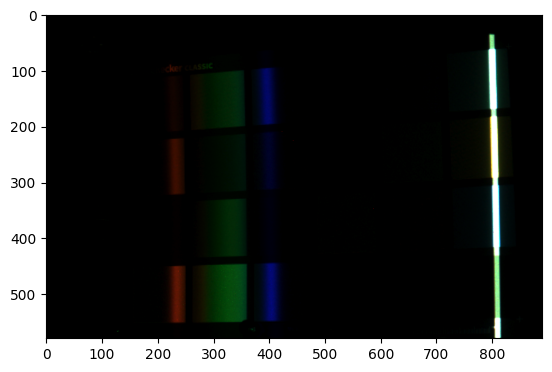

In [12]:
idx = 270
max_val = 65535
plt.imshow(hdr_imgs[idx] / (65535))

In [13]:
final_hdr = hdr_imgs.transpose(1,2,0,3)

In [14]:
final_hdr.shape

(580, 890, 318, 3)

### patches rgb real

In [15]:
# plot reflectance for each patches - real
# patches : 24개, wvl : 25 개
patches_rgb_real = np.zeros(shape = (n_illum, n_patches, n_channel))

cnst = 1
patch_size = 5

# max value defined for each illumination pattern 

for l in range(318):
        y_idx_start, y_idx_end = (all_patches_center_pts[:,1] - patch_size//2).astype(np.int32), (all_patches_center_pts[:,1] + patch_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (all_patches_center_pts[:,0] - patch_size//2).astype(np.int32), (all_patches_center_pts[:,0] + patch_size//2).astype(np.int32)
        
        for p in range(n_patches):
                y_idx, x_idx = all_patches_center_pts[p,1], all_patches_center_pts[p,0]
                rgb_intensity = (final_hdr[y_idx_start[p]:y_idx_end[p], x_idx_start[p]:x_idx_end[p], l] / (65535)).reshape(-1, 3).mean(axis = 0)
                patches_rgb_real[l, p] = rgb_intensity

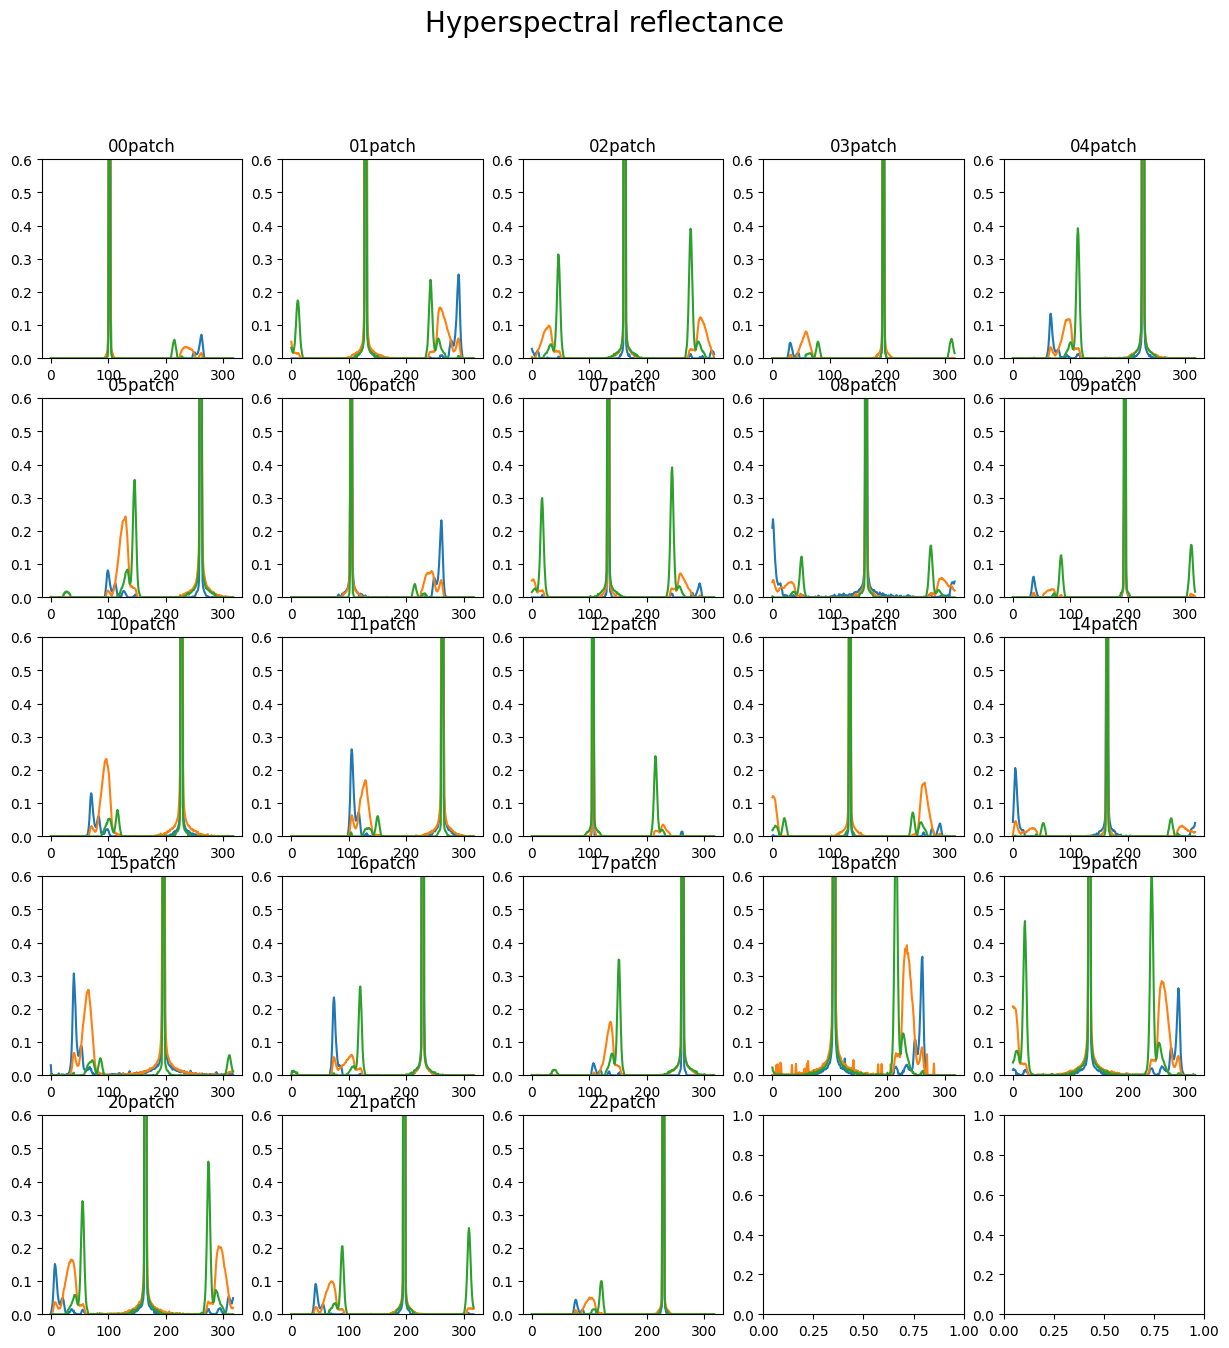

In [16]:
# Creating a figure
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('Hyperspectral reflectance', fontsize=20)

# Plotting data
for i, ax in enumerate(axs.flat[:23]):
    ax.set_ylim(0, 0.6)
    ax.plot(patches_rgb_real[:,i])
    ax.set_title('%02dpatch'%i)

### First illum index

In [58]:
first_illum_idx = np.load(os.path.join('../../dataset/image_formation/20231007/npy_data/first_illum_idx_final_transp_test_2.npy')) # num patch, wvls (430nm - 660nm except 630nm)

In [18]:
first_illum_idx.shape

(301, 47, 516200)

In [19]:
first_illum_idx = first_illum_idx.reshape(len(depth_arange),len(new_wvls),cam_H*cam_W)

In [20]:
first_illum_idx[first_illum_idx < 0] = 0
first_illum_idx[first_illum_idx > 317] = 317

### Zero order

In [21]:
zero_illum_idx = np.zeros(shape=(cam_H * cam_W))
hdr_imgs_reshape = hdr_imgs.reshape(n_illum, cam_H*cam_W, 3)

for i in range(cam_H*cam_W):
    max_idx = np.argmax(hdr_imgs_reshape[:,i].mean(axis = 1))
    zero_illum_idx[i] = max_idx

zero_illum_idx = np.round(zero_illum_idx)

In [22]:
zero_illum_idx = zero_illum_idx.reshape(cam_H, cam_W)[all_patches_center_pts[:,1], all_patches_center_pts[:,1]]

### Depth

In [23]:
if date == "1003":
    depth = np.load(os.path.join(real_data_dir,'2023%s_color_checker.npy'%date))[:,:,2]*1e+3
else:
    depth = np.load(os.path.join(real_data_dir,'./2023%s_depth.npy'%date))[:,:,2]*1e+3

(<matplotlib.image.AxesImage at 0x20d81a03488>,
 <matplotlib.colorbar.Colorbar at 0x20d81a0afc8>)

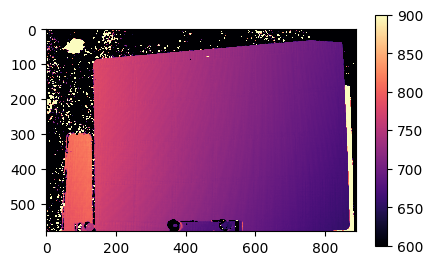

In [24]:
plt.figure(figsize=(5,3))
plt.imshow(depth, vmin=600, vmax = 900, cmap='magma'), plt.colorbar()

In [25]:
depth = np.round(depth).reshape(cam_H* cam_W).astype(np.int16)

In [127]:
depth_reshape = depth.reshape(cam_H, cam_W)[all_patches_center_pts[:,1],all_patches_center_pts[:,0]]
# depth scalar
A =  3.5 * 1e+5 # 10 * 1e+5 for peak # 4 * 1e+5 for tree
depth_scalar = ((depth_reshape.astype(np.int32))**2) / A

In [128]:
depth_scalar

array([1.71164571, 1.63296   , 1.55191143, 1.50593143, 1.43623143,
       1.38007143, 1.66334   , 1.61143143, 1.53511143, 1.48938286,
       1.41604571, 1.35241143, 1.68960286, 1.61143143, 1.52674571,
       1.44028571, 1.39600286, 1.33282571, 1.62433143, 1.55191143,
       1.51008286, 1.41202571, 1.36818286, 1.27874571])

In [26]:
real_img_illum_idx = np.zeros(shape=(len(new_wvls), cam_H*cam_W))
for i in range(cam_H*cam_W):
        if (depth[i] < 600) or (depth[i] > 900):
                depth[i] = 600
        depth_idx = np.where(depth_arange == depth[i])[0][0]
        real_img_illum_idx[:,i]= first_illum_idx[depth_idx,:,i]

In [27]:
real_img_illum_idx.shape

(47, 516200)

In [33]:
real_img_illum_idx = real_img_illum_idx.reshape(len(new_wvls), cam_H, cam_W)[:, all_patches_center_pts[:,1], all_patches_center_pts[:,0]]

In [34]:
real_img_illum_idx = real_img_illum_idx.astype(np.int16)

In [37]:
real_img_illum_idx.shape

(47, 24)

### Diffraction grating efficiency

In [38]:
# DG efficiency for all pixels
DG_efficiency_image = np.zeros(shape=(len(new_wvls), n_patches))

for i in range(n_patches):
    if zero_illum_idx[i] > real_img_illum_idx[0,i]: # 430nm # -1 order
        DG_efficiency_image[:,i] =  DG_efficiency[0]

    elif zero_illum_idx[i] < real_img_illum_idx[0,i]: # +1 order
        DG_efficiency_image[:,i] =  DG_efficiency[2]
    else: # else
        DG_efficiency_image[:,i] = 0

In [96]:
DG_efficiency.shape

(3, 47)

### GT and Simulation plotting

In [41]:
CRF_intp.T.shape

(47, 3)

In [42]:
# test with GT reflectance for all patches
total_patch = []
for p in range(n_patches):
    I_C = ref_CC[:,p][:,np.newaxis] * CRF_intp.T * white_patt_hyp[:,np.newaxis] * DG_efficiency_image[:,p][:,np.newaxis]

    total_patch.append(I_C)
total_patch = np.array(total_patch)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


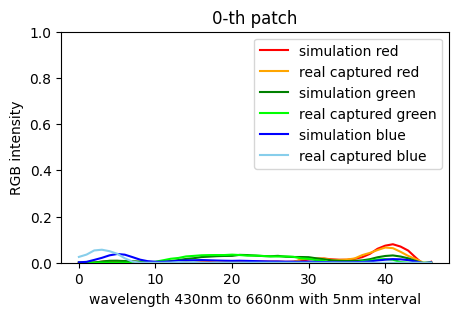

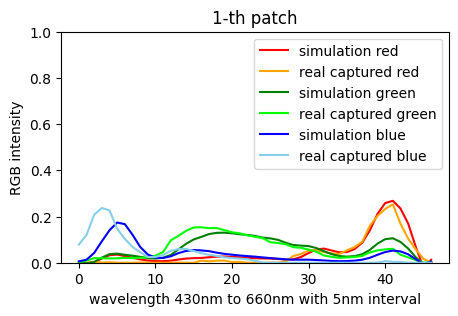

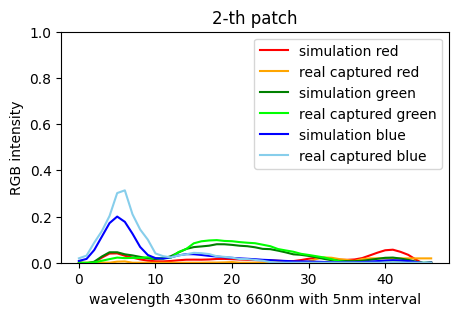

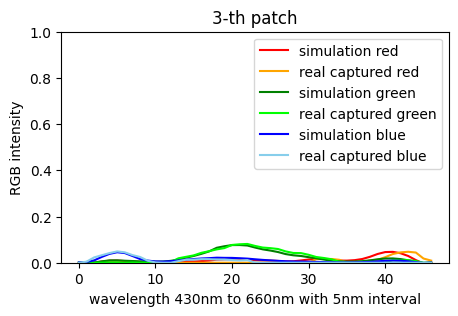

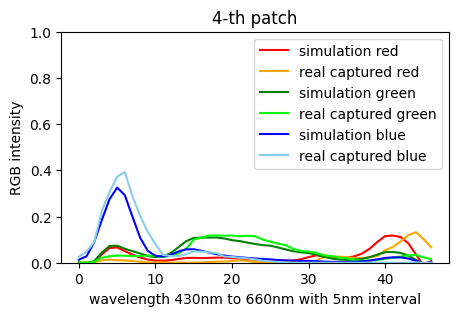

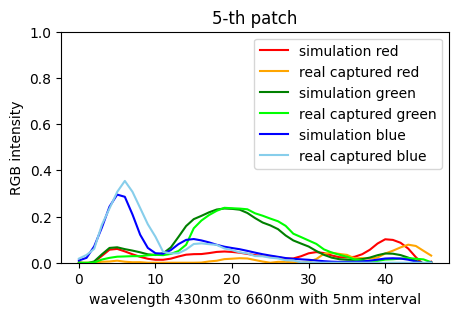

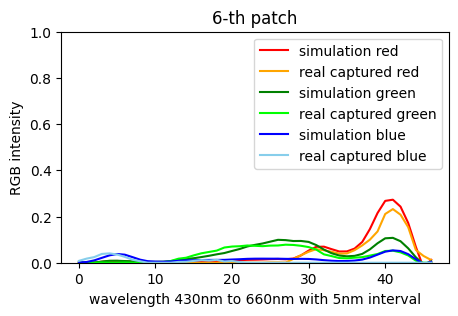

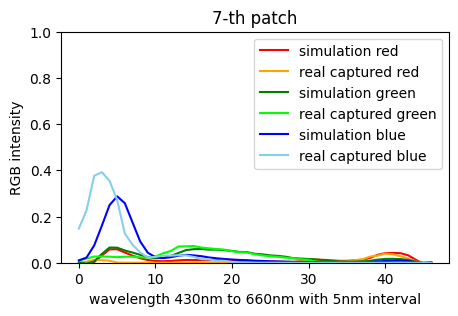

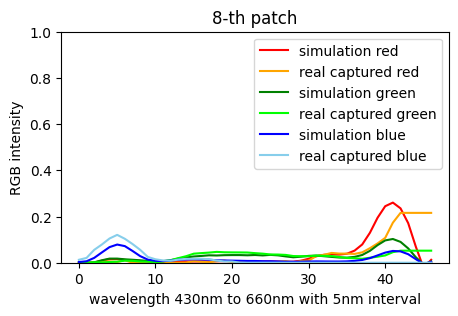

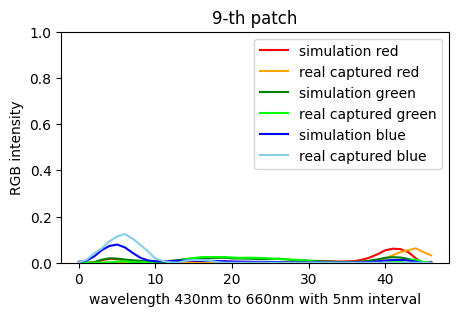

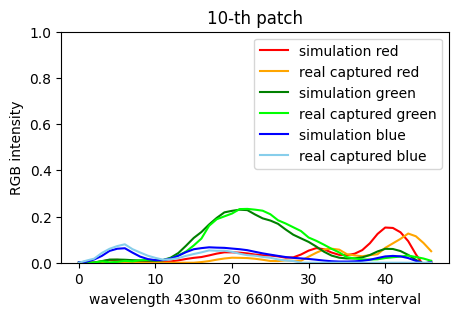

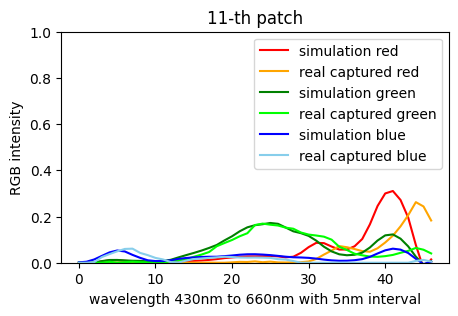

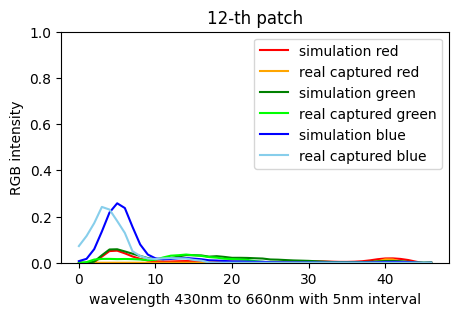

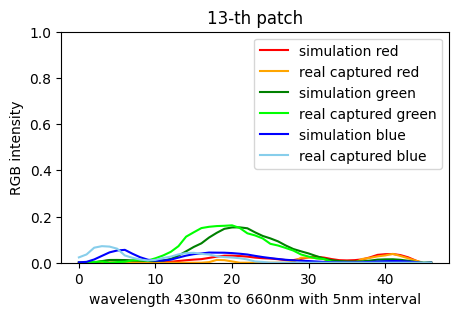

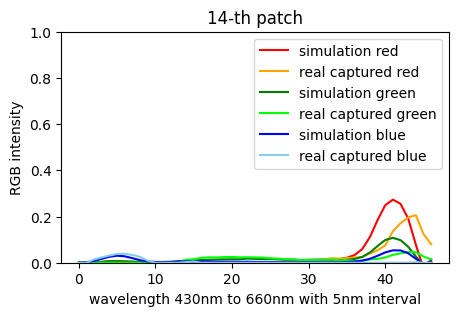

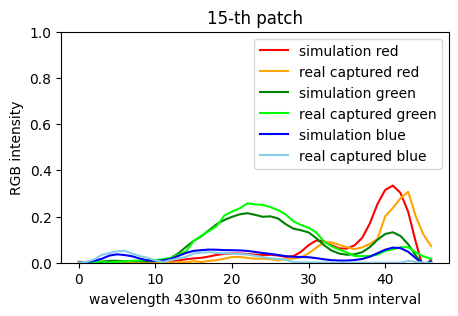

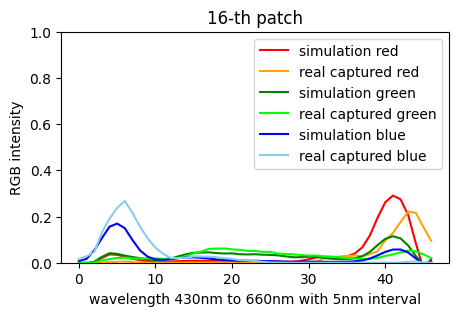

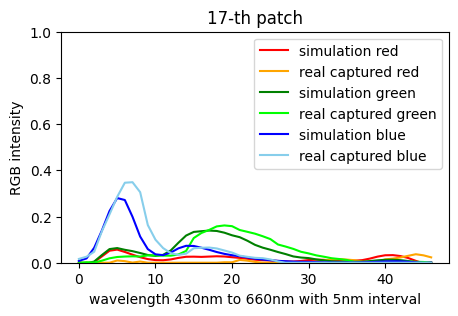

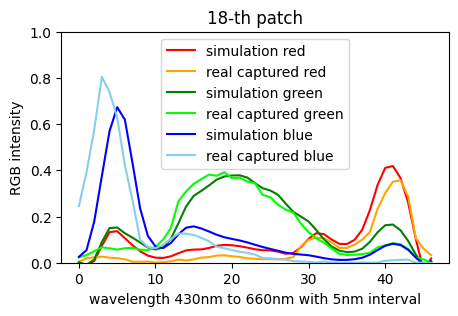

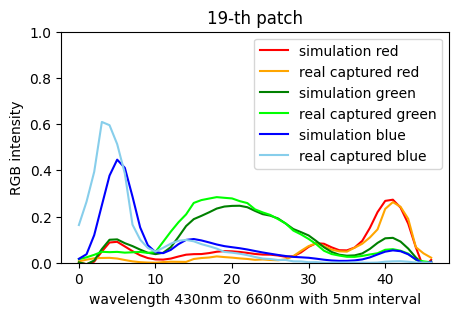

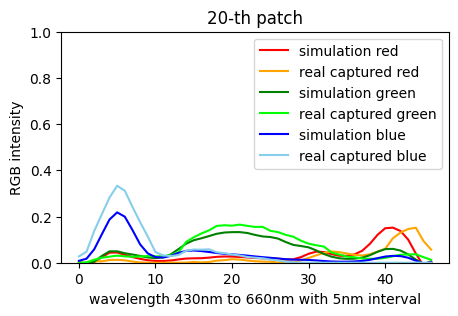

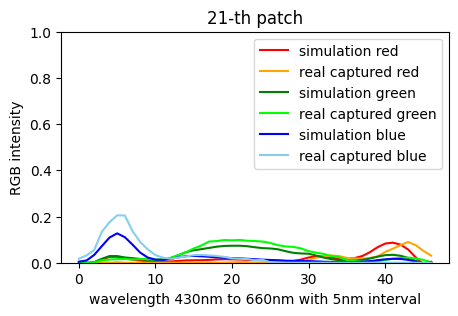

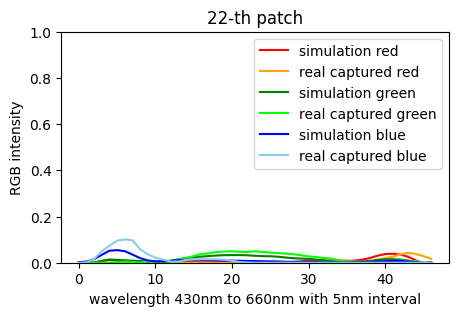

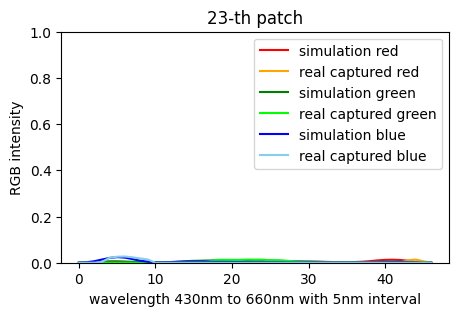

In [44]:
constant = 5
max_ylim = 0.9
patch_num = 1

# plot 1st order rgb intensity for all patches
for p in range(0, 24): # only visualize white patch
    plt.figure(figsize=(5,3))
    plt.ylim([0, 1])    

    # red
    plt.plot(total_patch[p][:,0] * constant, c = 'red', label = 'simulation red')
    plt.plot(patches_rgb_real[real_img_illum_idx[:,p], p][:,0], c = 'orange', label = 'real captured red')
    plt.legend()

    # green
    plt.plot(total_patch[p][:,1]* constant, c = 'green', label = 'simulation green')
    plt.plot(patches_rgb_real[real_img_illum_idx[:,p], p][:,1], c = 'lime', label = 'real captured green')
    plt.legend()
    
    # blue
    plt.plot(total_patch[p][:,2]* constant, c = 'blue', label = 'simulation blue')
    plt.plot(patches_rgb_real[real_img_illum_idx[:,p], p][:,2], c = 'skyblue', label = 'real captured blue')
    
    plt.xlabel('wavelength 430nm to 660nm with 5nm interval')
    plt.ylabel('RGB intensity')
    plt.title('%s-th patch'%p)
    plt.legend()

In [46]:
DG_efficiency_image.shape

(47, 24)

### Optimization

PEF, CRF, DG, PEF&CRF, PEF&DG, CRF&DG, PEF&CRF&DG

#### PEF, CRF optimization

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0/10000, Loss: 0.004050447046756745, LR: 0.001


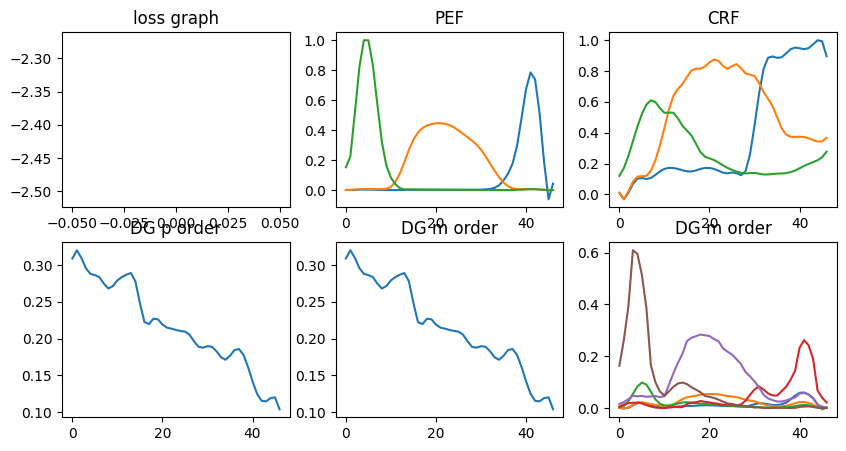

Epoch : 500/10000, Loss: 0.002303733676671982, LR: 0.001


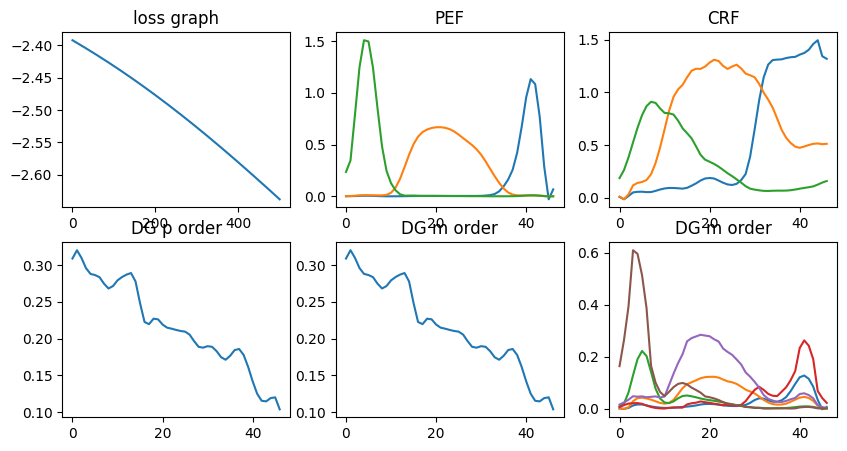

Epoch : 1000/10000, Loss: 0.001209843996912241, LR: 0.001


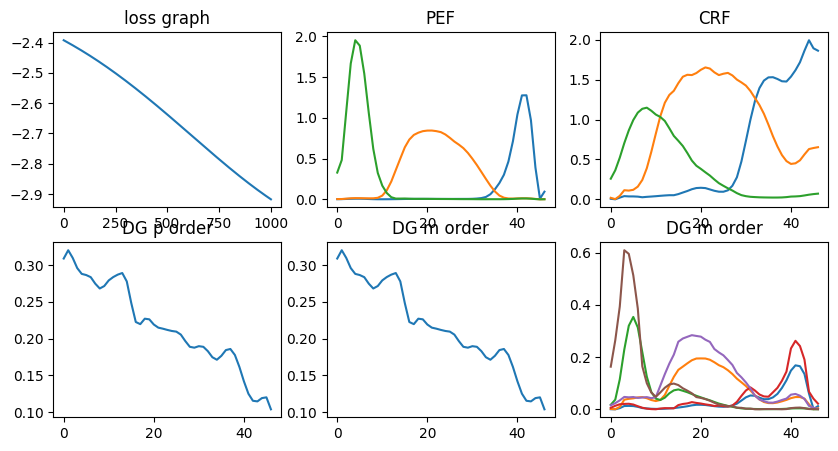

KeyboardInterrupt: 

In [112]:
# arguments
device = 'cuda:0'
epoch = 10000
loss_f = torch.nn.MSELoss()
losses = [] 

# Height, width of image
H, W = 1, 1

# dg order
pfirst_patches = [0, 6, 12, 18, 1, 7, 13, 19]

# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, 3), device = device, dtype = torch.float)*0.8

# learning rate & decay step
lr = 0.001
decay_step = 5000
gamma = 0.5

# optimized paramter (CRF & PEF)
# initial_value = torch.ones(size =(47, 8))
initial_value = torch.ones(size =(47, 6))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF = torch.tensor(PEF_intp, dtype = torch.float).to(device).T
CRF = torch.tensor(CRF_intp, dtype = torch.float).to(device).T
dg_intensity = torch.tensor(DG_efficiency_image, dtype = torch.float).to(device).T
ref_CC = torch.tensor(ref_CC, dtype = torch.float).to(device)
patches_rgb_real_device = torch.tensor(patches_rgb_real, dtype = torch.float).to(device)
peak_illum_idx_final_device = torch.tensor(real_img_illum_idx, dtype = torch.long).to(device)
depth_scalar_dev = torch.tensor(depth_scalar, dtype = torch.float).to(device).T

opt_patch_idx = [random.randint(0,23) for i in range(15)] 
# opt_patch_idx = [0, 12, 13, 14, 16, 8]

for i in range(epoch):
    # initial loss
    loss = 0
    
    PEF_opt = opt_param[:,:3] * PEF
    CRF_opt = opt_param[:,3:] * CRF
    # CRF_opt = opt_param[:,3:-2] * CRF
    # dg_intensity_mfirst_opt = opt_param[:,-2] * dg_intensity[:,0]
    # dg_intensity_pfirst_opt = opt_param[:,-1] * dg_intensity[:,2]

    CRF_sum = CRF_opt.sum(axis = 1)
    
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_opt.T

    # loss for all patches
    for p in range(n_patches-4):

        Simulated_I_RGB = ref_CC[:,p].unsqueeze(dim = 1) * CRF_opt * white_pattern_hyp.T * dg_intensity[p].unsqueeze(dim = 1) / depth_scalar_dev[p] 
        GT_I_RGB = patches_rgb_real_device[peak_illum_idx_final_device[:,p], p]
                
        single_patch_loss = loss_f(Simulated_I_RGB, GT_I_RGB)
        loss += single_patch_loss.sum()
    
    CRF_dL2 = ((CRF_opt[:-1] - CRF_opt[1:])**2).sum()
    PEF_dL2 = ((PEF_opt[:-1] - PEF_opt[1:])**2).sum()
    # DGM_dL2 = ((dg_intensity_mfirst_opt[:-1] - dg_intensity_mfirst_opt[1:])**2).sum()
    # DGP_dL2 = ((dg_intensity_pfirst_opt[:-1] - dg_intensity_pfirst_opt[1:])**2).sum()
    
    weight = 0.0005
    loss += weight*(CRF_dL2 + PEF_dL2)
    # loss += weight*(CRF_dL2 + PEF_dL2 + DGM_dL2 + DGP_dL2)

    loss = loss.sum()
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / (num_patch-4))

    optimizer.step()
    scheduler.step()
        
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / (num_patch-4)}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()
        Simulated_I_RGB_detach = Simulated_I_RGB.detach().cpu().numpy()
        GT_I_RGB_detach = GT_I_RGB.detach().cpu().numpy()
        
        np.save('./opt_params/opt_param_1021_detach_%05d.npy'%i, opt_param_detach)
        
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses]), plt.title('loss graph')
        
        # CRF & PEF
        plt.subplot(232), plt.plot(PEF_opt.detach().cpu().numpy()), plt.title('PEF')
        plt.subplot(233), plt.plot(CRF_opt.detach().cpu().numpy()), plt.title('CRF')
        plt.subplot(234), plt.plot(dg_intensity[0].detach().cpu().numpy()), plt.title('DG p order')
        plt.subplot(235), plt.plot(dg_intensity[5].detach().cpu().numpy()), plt.title('DG m order')

        plt.subplot(236), plt.plot(Simulated_I_RGB_detach), plt.title('DG m order')
        plt.subplot(236), plt.plot(GT_I_RGB_detach), plt.title('DG m order')
        plt.show()

#### PEF, CRF, DG optimization

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0/10000, Loss: 0.03129283785820007, LR: 0.001


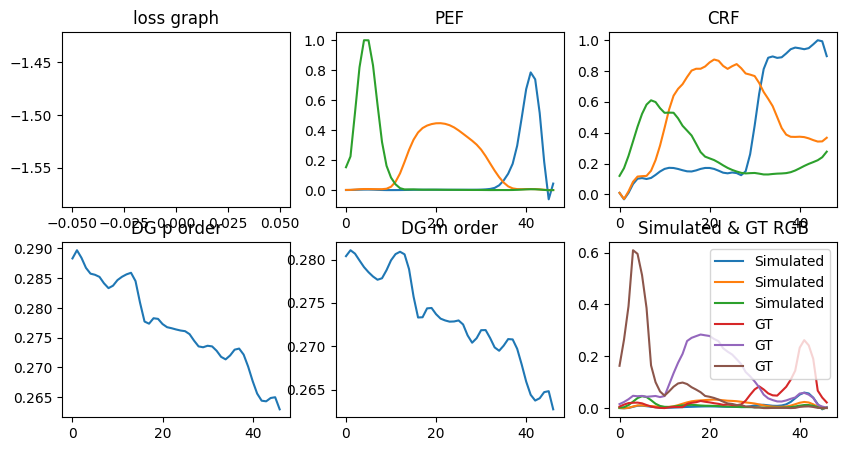

Epoch : 500/10000, Loss: 0.025589263439178465, LR: 0.001


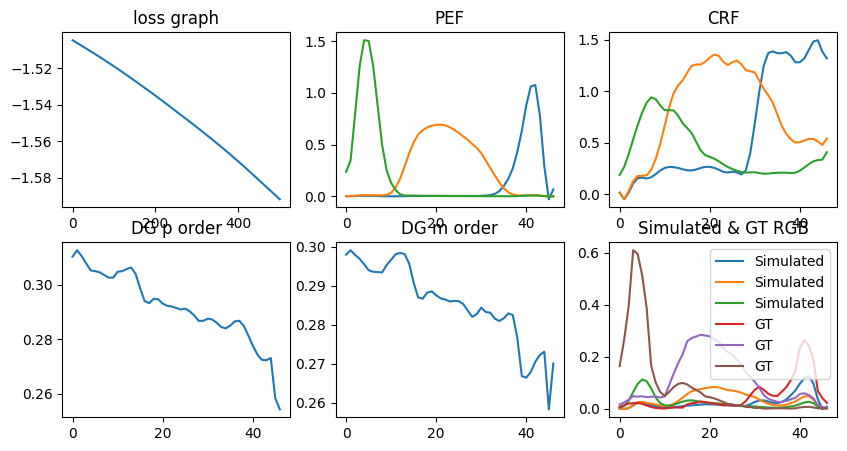

Epoch : 1000/10000, Loss: 0.019558051228523256, LR: 0.001


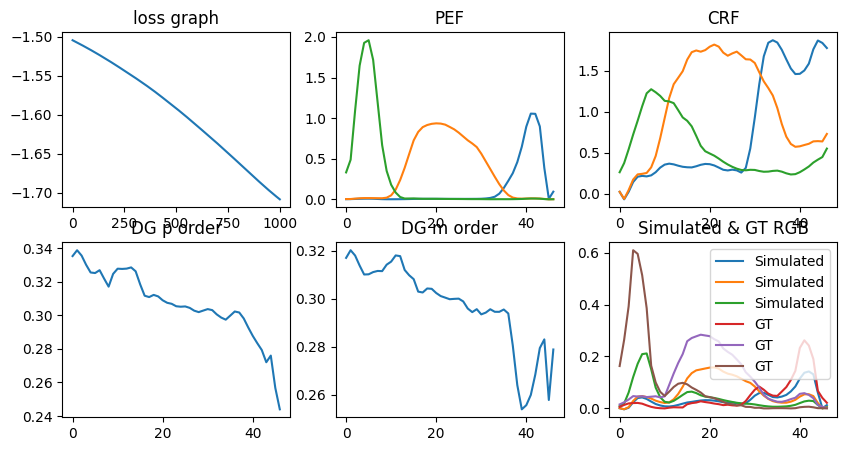

Epoch : 1500/10000, Loss: 0.016694098711013794, LR: 0.001


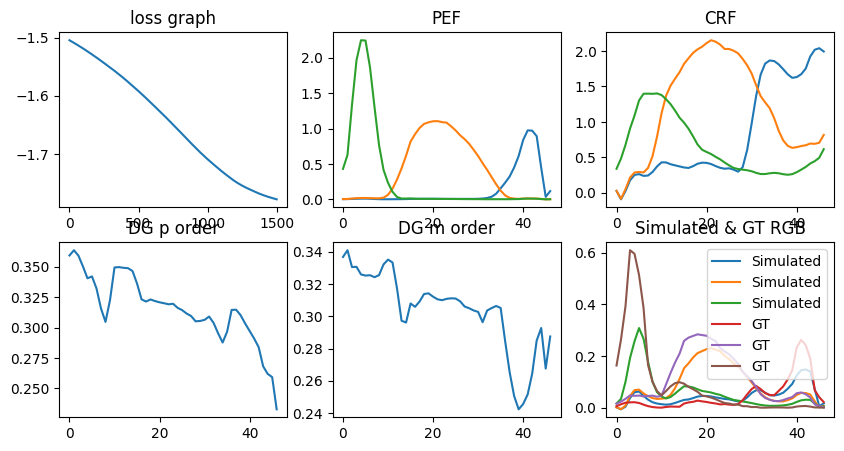

Epoch : 2000/10000, Loss: 0.01584877520799637, LR: 0.001


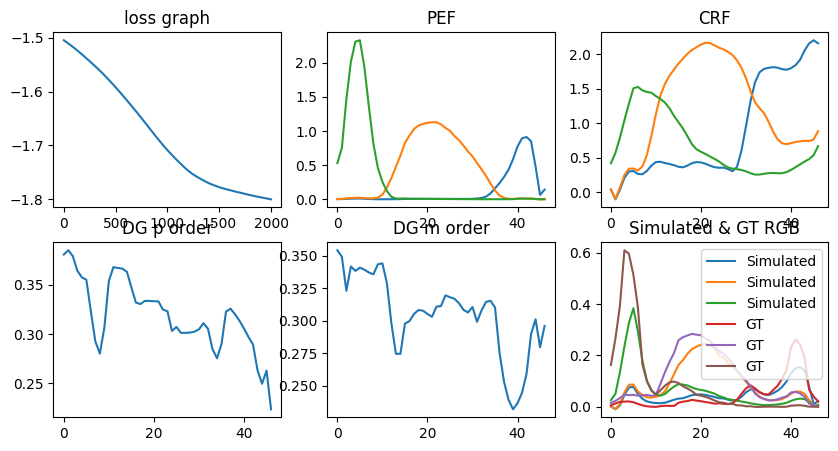

Epoch : 2500/10000, Loss: 0.015276725590229034, LR: 0.001


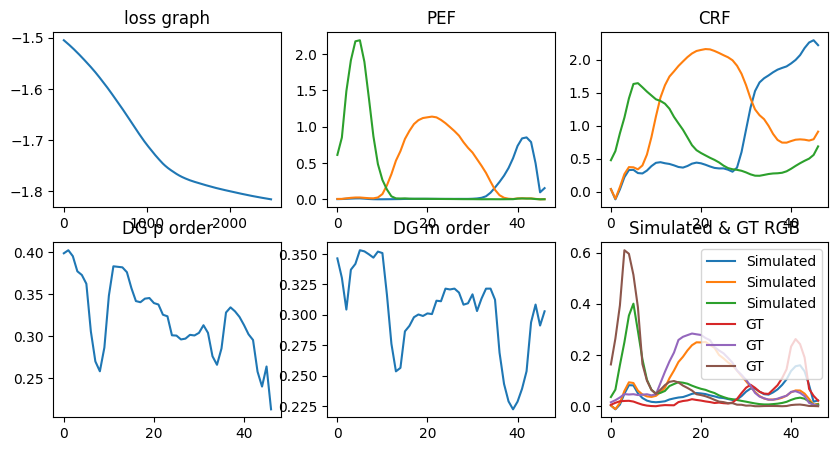

Epoch : 3000/10000, Loss: 0.01484648883342743, LR: 0.001


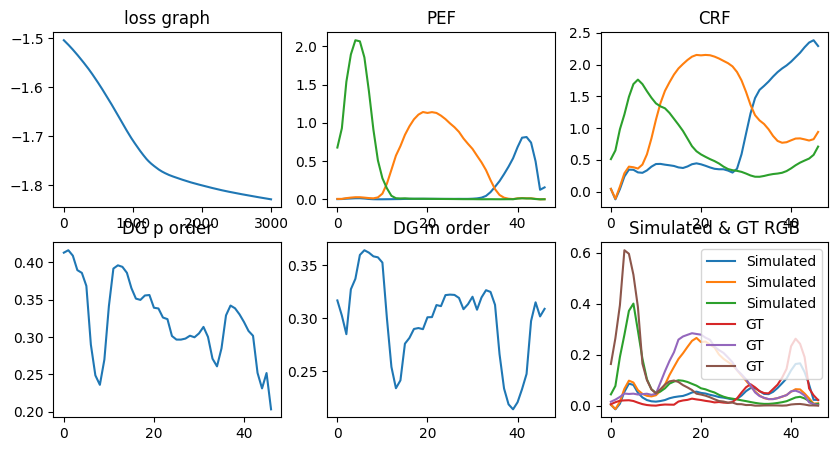

Epoch : 3500/10000, Loss: 0.014483264088630677, LR: 0.001


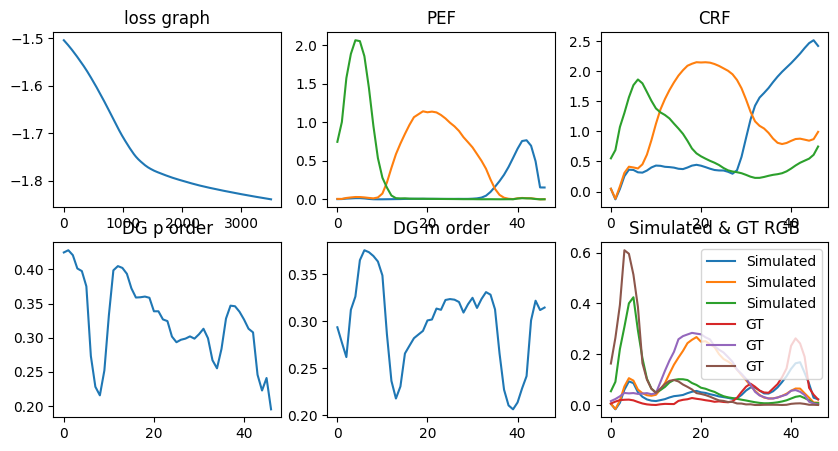

Epoch : 4000/10000, Loss: 0.014162865281105042, LR: 0.001


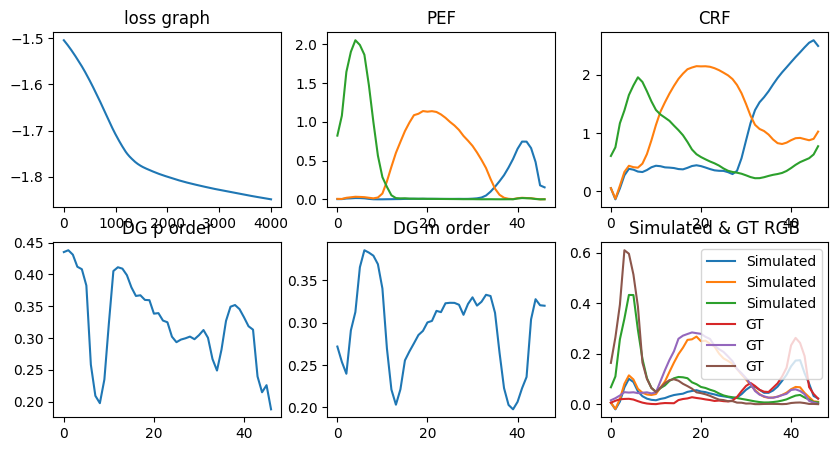

Epoch : 4500/10000, Loss: 0.01387963593006134, LR: 0.001


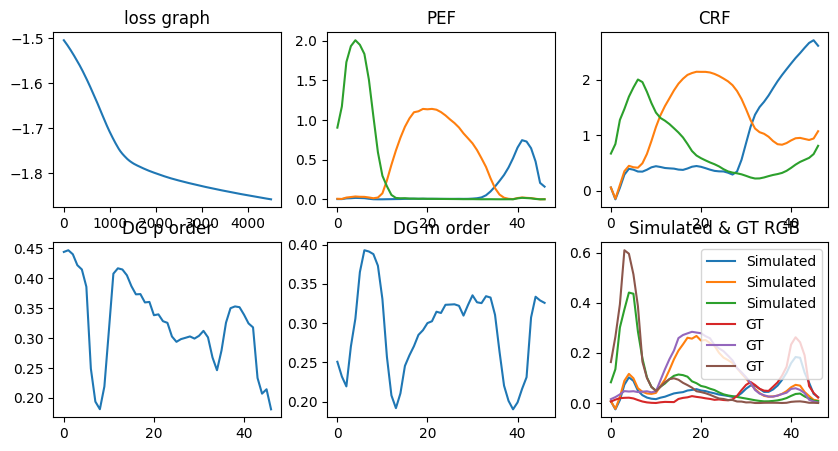

Epoch : 5000/10000, Loss: 0.013622401654720307, LR: 0.0005


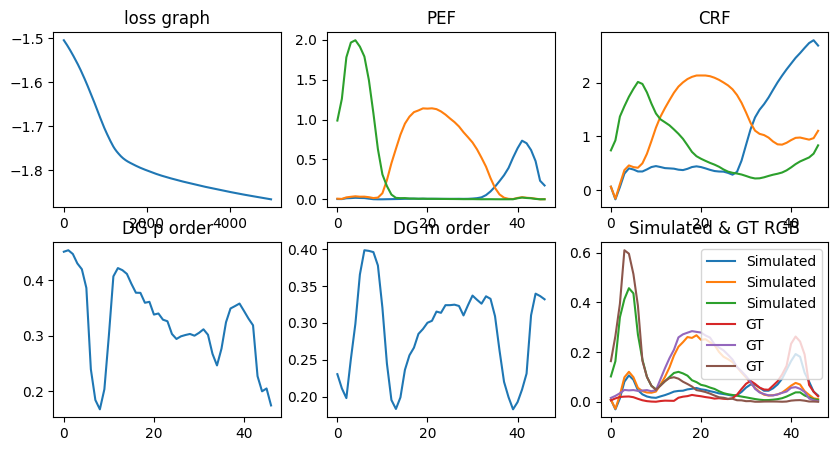

Epoch : 5500/10000, Loss: 0.01350286453962326, LR: 0.0005


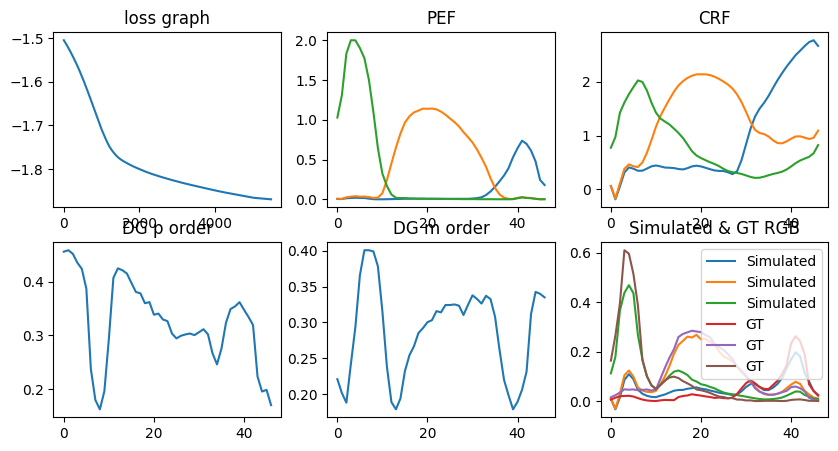

Epoch : 6000/10000, Loss: 0.013391105830669403, LR: 0.0005


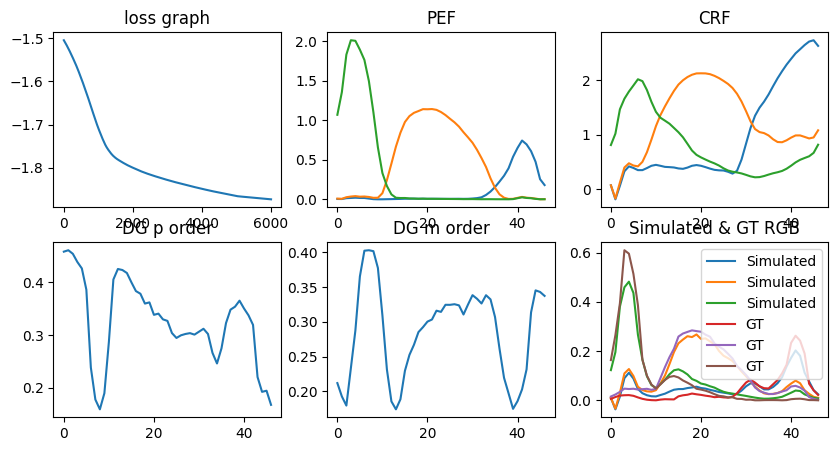

Epoch : 6500/10000, Loss: 0.013293413817882538, LR: 0.0005


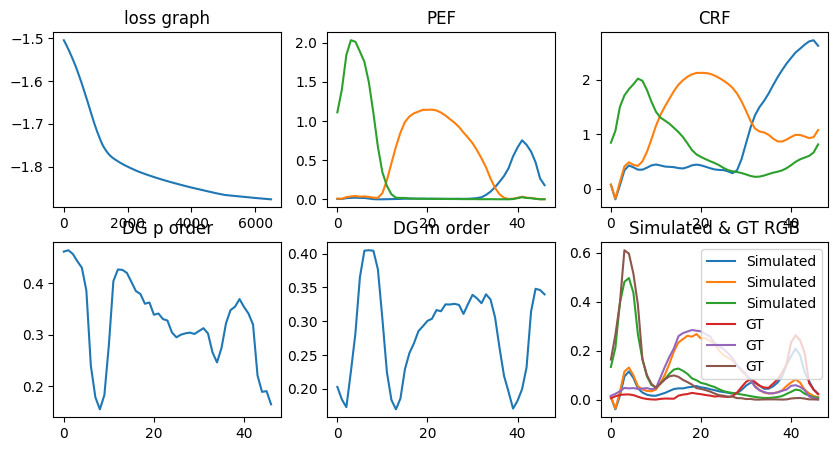

Epoch : 7000/10000, Loss: 0.013207806646823883, LR: 0.0005


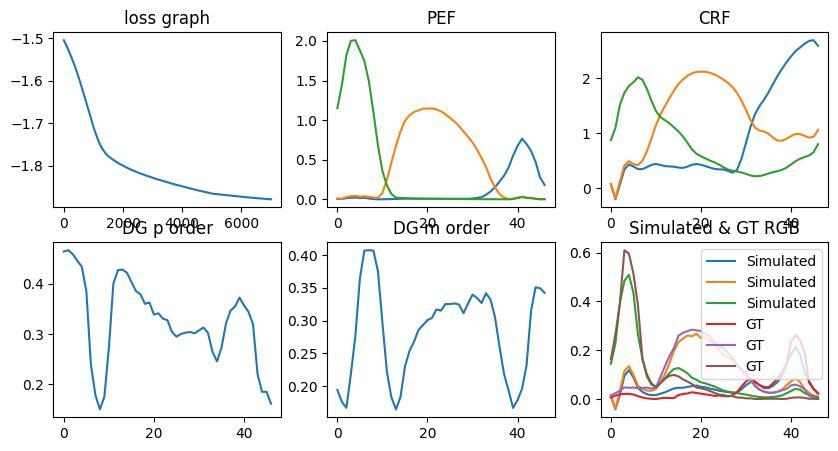

Epoch : 7500/10000, Loss: 0.013137443363666535, LR: 0.0005


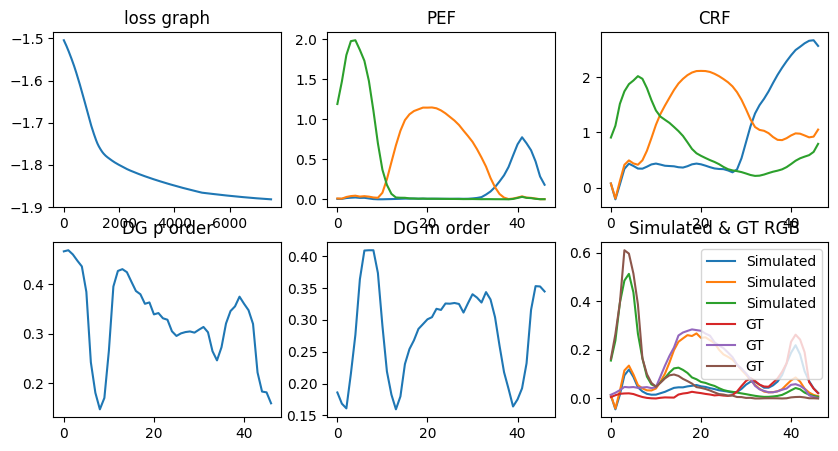

Epoch : 8000/10000, Loss: 0.013078004121780396, LR: 0.0005


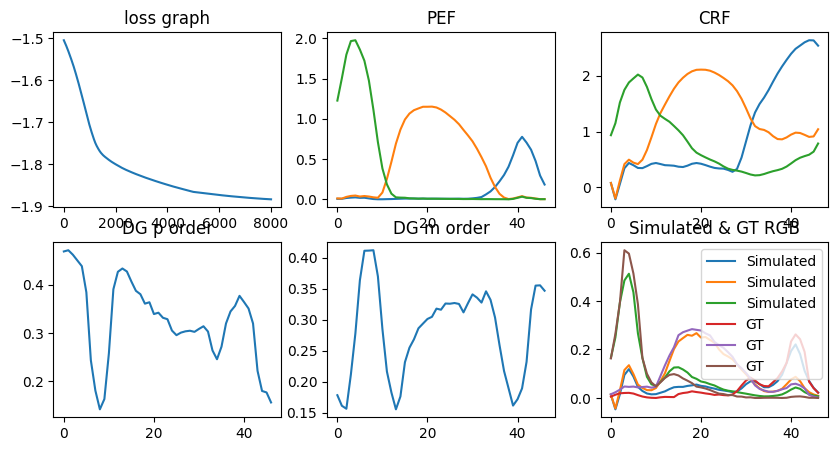

Epoch : 8500/10000, Loss: 0.013031452894210815, LR: 0.0005


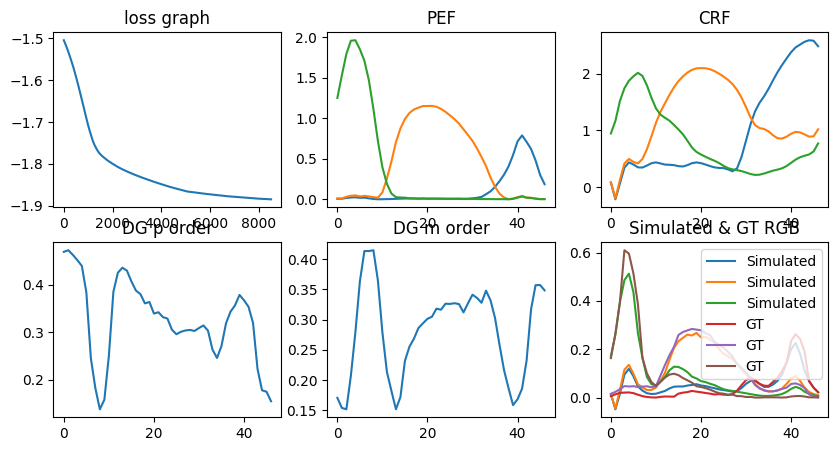

Epoch : 9000/10000, Loss: 0.012990535795688629, LR: 0.0005


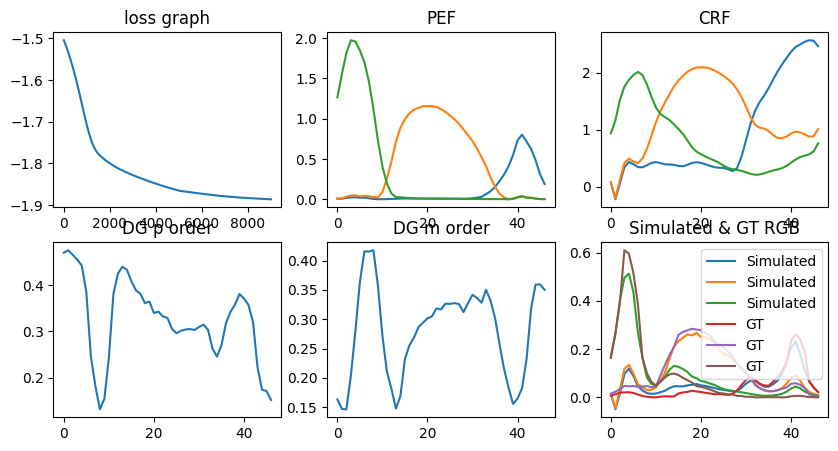

Epoch : 9500/10000, Loss: 0.0129532590508461, LR: 0.0005


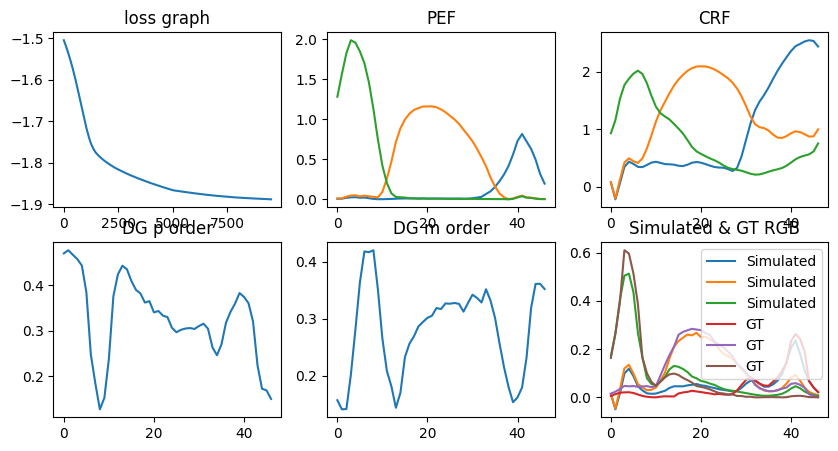

In [130]:
# arguments
device = 'cuda:0'
epoch = 10000
loss_f = torch.nn.L1Loss()
losses = [] 

# Height, width of image
H, W = 1, 1

# dg order
pfirst_patches = [0, 6, 12, 18, 1, 7, 13, 19]

# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, 3), device = device, dtype = torch.float)*0.8

# learning rate & decay step
lr = 0.001
decay_step = 5000
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(47, 6))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF = torch.tensor(PEF_intp, dtype = torch.float).to(device).T
CRF = torch.tensor(CRF_intp, dtype = torch.float).to(device).T
dg_intensity = torch.tensor(DG_efficiency, dtype = torch.float).to(device).T
ref_CC = torch.tensor(ref_CC, dtype = torch.float).to(device)
patches_rgb_real_detach = torch.tensor(patches_rgb_real, dtype = torch.float).to(device)
peak_illum_idx_final_detach = torch.tensor(real_img_illum_idx, dtype = torch.long).to(device)
depth_scalar_dev = torch.tensor(depth_scalar, dtype = torch.float).to(device).T

opt_patch_idx = [18, 8]

for i in range(epoch):
    # initial loss
    loss = 0
    
    PEF_opt = opt_param[:,:3] * PEF
    CRF_opt = opt_param[:,3:-2] * CRF
    dg_intensity_mfirst_opt = torch.sigmoid(opt_param[:,-2] * dg_intensity[:,0]) * 1/2
    dg_intensity_pfirst_opt = torch.sigmoid(opt_param[:,-1] * dg_intensity[:,2]) * 1/2
    
    CRF_sum = CRF_opt.sum(axis = 1)
    
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_opt.T

    # loss for all patches
    # for p in opt_patch_idx:
    for p in range(n_patches-4):
        if p in pfirst_patches:
            dg_efficiency = dg_intensity_pfirst_opt
        else:
            dg_efficiency = dg_intensity_mfirst_opt

        Simulated_I_RGB = ref_CC[:,p].unsqueeze(dim = 1) * CRF_opt * white_pattern_hyp.T * dg_efficiency.unsqueeze(dim = 1) / depth_scalar_dev[p]
        GT_I_RGB = patches_rgb_real_detach[peak_illum_idx_final_detach[:,p], p]
                
        single_patch_loss = loss_f(Simulated_I_RGB, GT_I_RGB)
        loss += single_patch_loss.sum()
    
    CRF_dL2 = ((CRF_opt[:-1] - CRF_opt[1:])**2).sum()
    PEF_dL2 = ((PEF_opt[:-1] - PEF_opt[1:])**2).sum()
    DGM_dL2 = ((dg_intensity_mfirst_opt[:-1] - dg_intensity_mfirst_opt[1:])**2).sum()
    DGP_dL2 = ((dg_intensity_pfirst_opt[:-1] - dg_intensity_pfirst_opt[1:])**2).sum()
    
    weight = 0.005
    loss += weight*(CRF_dL2 + PEF_dL2 + DGM_dL2 + DGP_dL2)
    loss = loss.sum()
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / (num_patch-4))
    optimizer.step()
    scheduler.step()
        
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / (num_patch-4)}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()
        Simulated_I_RGB_detach = Simulated_I_RGB.detach().cpu().numpy()
        GT_I_RGB_detach = GT_I_RGB.detach().cpu().numpy()
        
        np.save('./opt_params/opt_param_dg_detach_%05d.npy'%i, opt_param_detach)
        
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses]), plt.title('loss graph')
        
        # CRF & PEF
        plt.subplot(232), plt.plot(PEF_opt.detach().cpu().numpy()), plt.title('PEF')
        plt.subplot(233), plt.plot(CRF_opt.detach().cpu().numpy()), plt.title('CRF')
        plt.subplot(234), plt.plot(dg_intensity_pfirst_opt.detach().cpu().numpy()), plt.title('DG p order')
        plt.subplot(235), plt.plot(dg_intensity_mfirst_opt.detach().cpu().numpy()), plt.title('DG m order')

        plt.subplot(236), plt.plot(Simulated_I_RGB_detach, label = 'Simulated'), plt.title('Simulated & GT RGB')
        plt.subplot(236), plt.plot(GT_I_RGB_detach, label = 'GT')
        plt.legend()
        plt.show()

### PEF, CRF, DG Optimization with 0-order

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0/10000, Loss: 0.008376939730210737, LR: 0.05
Epoch : 500/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 1000/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 1500/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 2000/10000, Loss: 0.00025718530047346246, LR: 0.05
Epoch : 2500/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 3000/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 3500/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 4000/10000, Loss: 0.00025718530047346246, LR: 0.05
Epoch : 4500/10000, Loss: 0.00025718530047346246, LR: 0.05
Epoch : 5000/10000, Loss: 0.00025718530047346246, LR: 0.025


KeyboardInterrupt: 

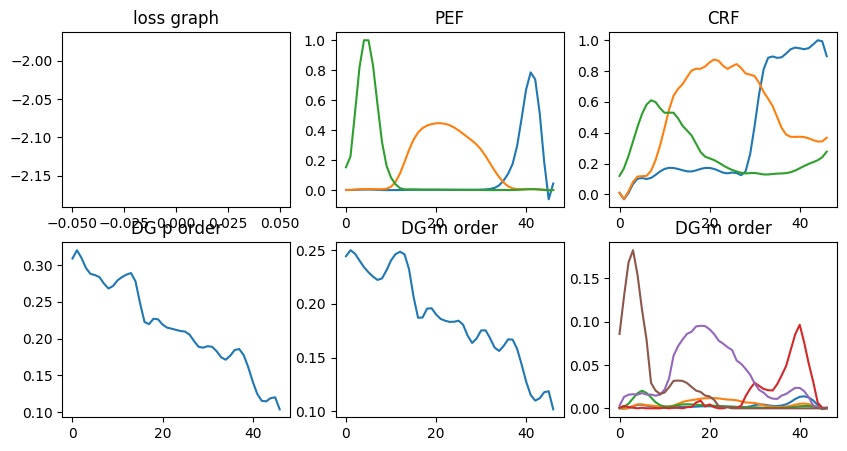

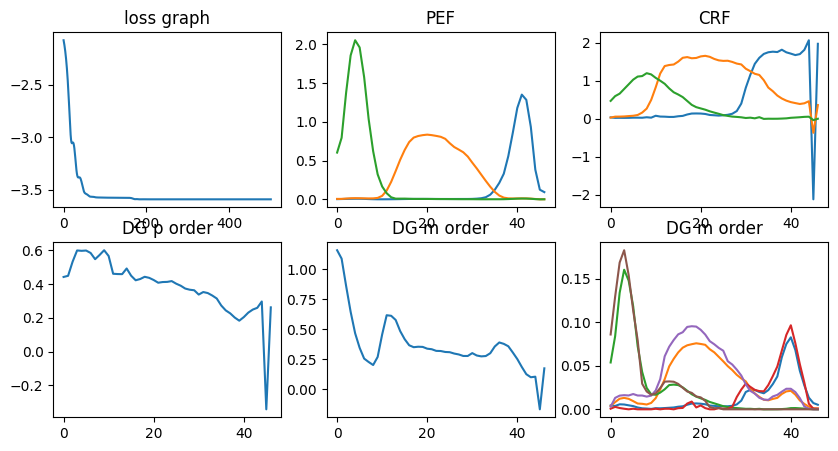

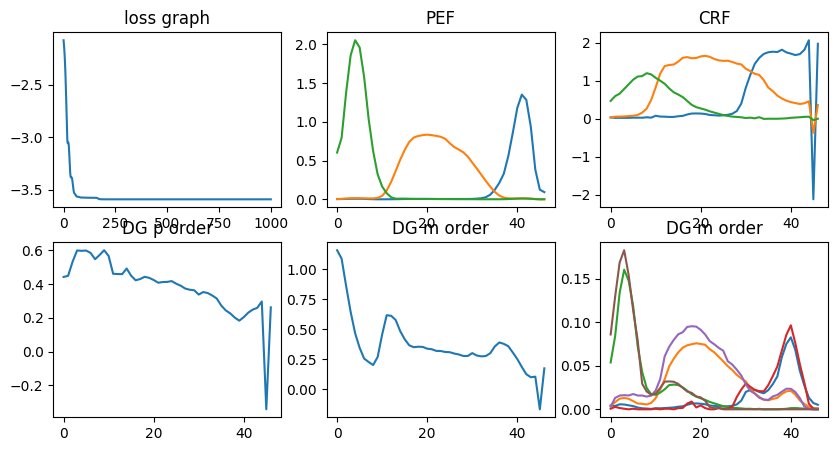

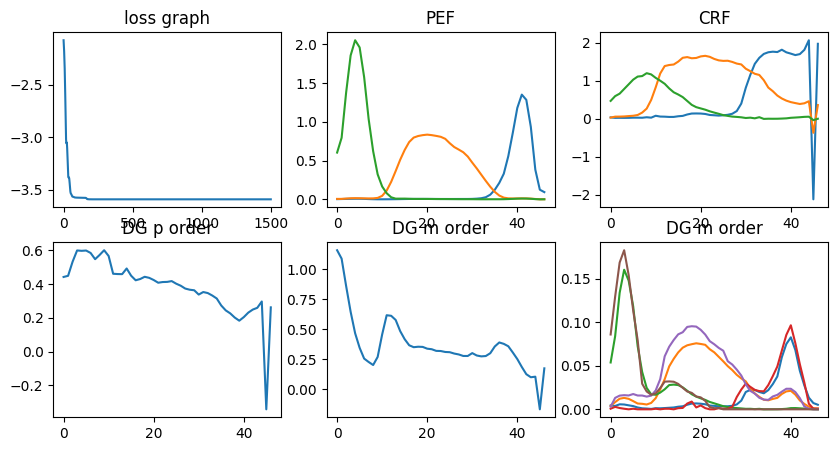

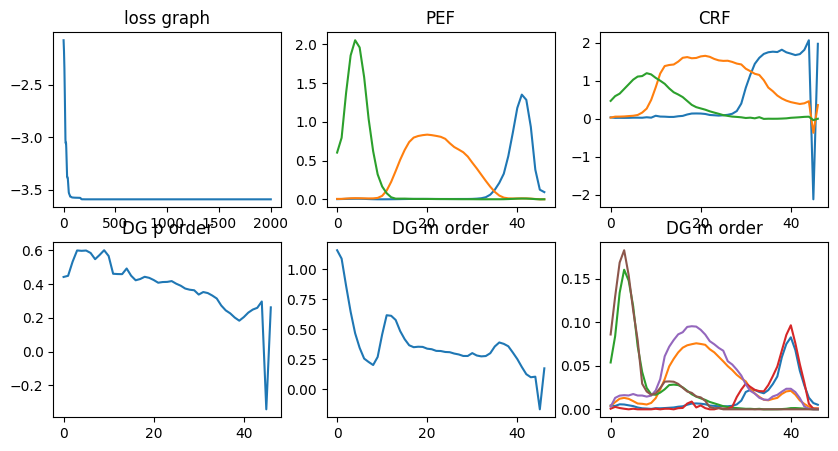

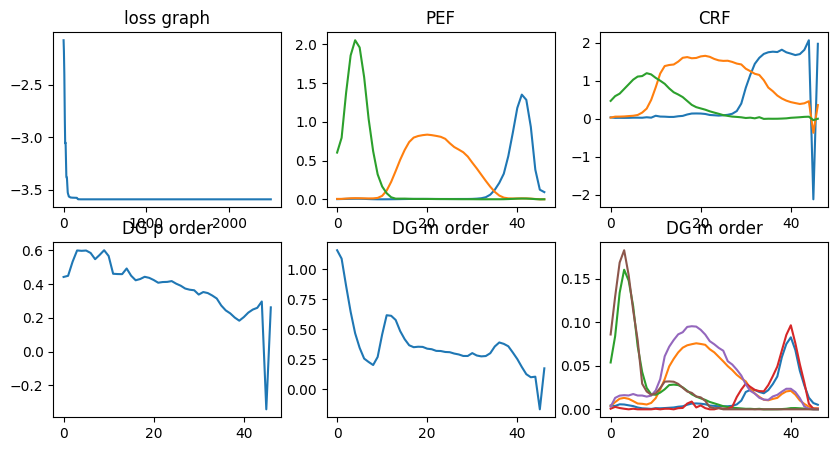

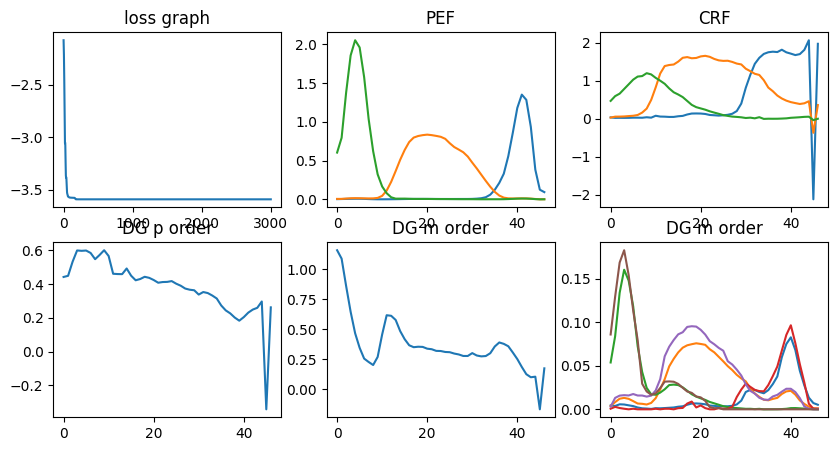

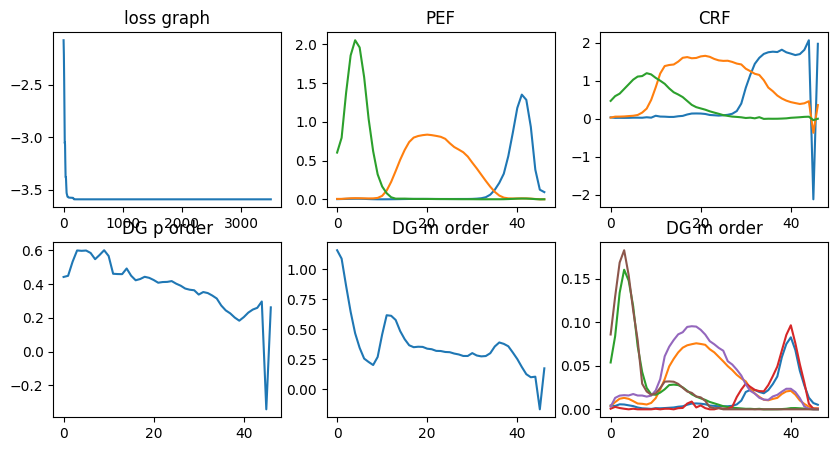

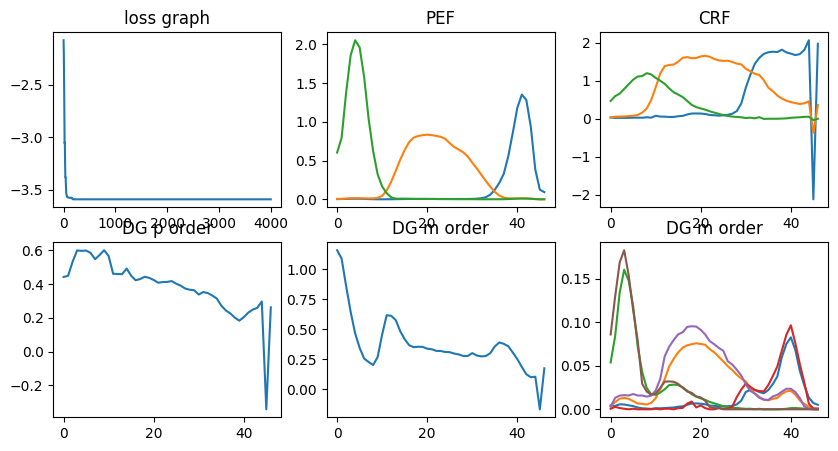

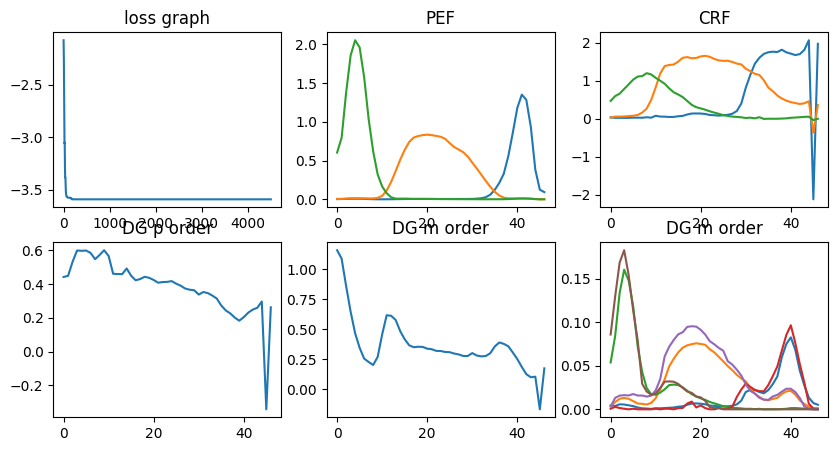

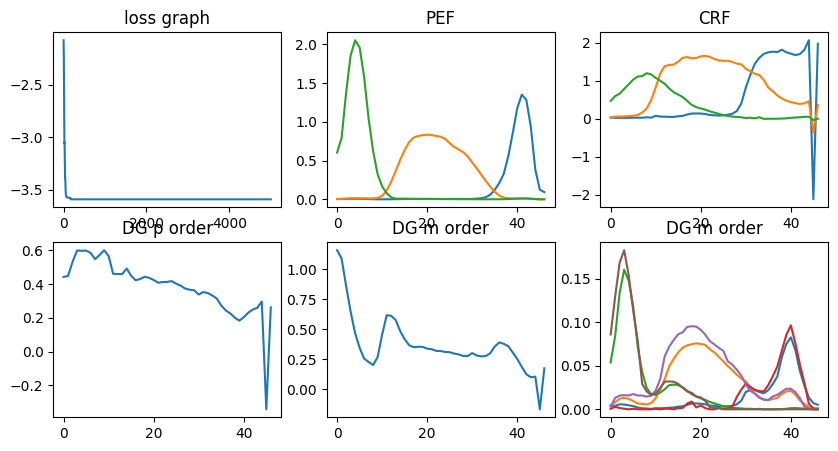

In [ ]:
# arguments
device = 'cuda:0'
epoch = 10000
loss_f = torch.nn.MSELoss()
losses = [] 

# Height, width of image
H, W = 1, 1

# dg order
pfirst_patches = [0, 6, 12, 18, 1, 7, 13, 19]

# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, 3), device = device, dtype = torch.float)*0.8

# learning rate & decay step
lr = 0.05
decay_step = 5000
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(47, 8))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF = torch.tensor(PEF_intp, dtype = torch.float).to(device).T
CRF = torch.tensor(CRF_intp, dtype = torch.float).to(device).T
dg_intensity = torch.tensor(dg_intensity_intp, dtype = torch.float).to(device).T
ref_CC = torch.tensor(ref_CC, dtype = torch.float).to(device)
patches_rgb_real_device = torch.tensor(patches_rgb_real, dtype = torch.float).to(device)
peak_illum_idx_final_device = torch.tensor(peak_illum_idx_final, dtype = torch.long).to(device)
rgb_correction = torch.tensor([0.04095889, 0.04477243, 0.04151389], device=device)
zero_illum_idx_final_device = torch.tensor(zero_illum_idx_final, dtype = torch.long).to(device)

opt_patch_idx = [random.randint(0,23) for i in range(15)] 
# opt_patch_idx = [0, 12, 13, 14, 16, 8]

for i in range(epoch):
    # initial loss
    loss = 0
    
    PEF_opt = opt_param[:,:3] * PEF
    CRF_opt = opt_param[:,3:-2] * CRF
    dg_intensity_mfirst_opt = opt_param[:,-2] * dg_intensity[:,0]
    dg_intensity_pfirst_opt = opt_param[:,-1] * dg_intensity[:,2]

    CRF_sum = CRF_opt.sum(axis = 1)
    
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_opt.T

    # loss for all patches
    # for p in opt_patch_idx:
    for p in range(n_patches-2):
        if p in pfirst_patches:
            dg_efficiency = dg_intensity_pfirst_opt
        else:
            dg_efficiency = dg_intensity_mfirst_opt

        # first order
        Simulated_I_RGB = ref_CC[:,p].unsqueeze(dim = 1) * CRF_opt * white_pattern_hyp.T * dg_efficiency.unsqueeze(dim = 1)
        GT_I_RGB = patches_rgb_real_device[peak_illum_idx_final_device[p], p]
        
        # zero order
        Simulated_Zero_RGB = (ref_CC[:,p].unsqueeze(dim = 0) * white_pattern_hyp) @ CRF_opt
        # GT_Zero_RGB = patches_rgb_real_device[zero_illum_idx_final_device[p,0], p] * rgb_correction

        single_patch_loss = loss_f(Simulated_I_RGB, GT_I_RGB)
        # zero_patch_loss = loss_f(Simulated_Zero_RGB.squeeze(), GT_Zero_RGB)
        
        loss = loss + single_patch_loss.sum() + zero_patch_loss.sum()
        # loss += single_patch_loss.sum()

    # CRF_dL2 = ((CRF_opt[:-1] - CRF_opt[1:])**2).sum()
    # PEF_dL2 = ((PEF_opt[:-1] - PEF_opt[1:])**2).sum()
    # DGM_dL2 = ((dg_intensity_mfirst_opt[:-1] - dg_intensity_mfirst_opt[1:])**2).sum()
    # DGP_dL2 = ((dg_intensity_pfirst_opt[:-1] - dg_intensity_pfirst_opt[1:])**2).sum()
    
    # weight = 0.0005
    # loss += weight*(CRF_dL2 + PEF_dL2 + DGM_dL2 + DGP_dL2)
    loss = loss.sum() * 10
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / (num_patch-2)*2)
    # losses.append(loss.item() / len(opt_patch_idx))

    optimizer.step()
    scheduler.step()
        
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / (num_patch-2)*2}, LR: {optimizer.param_groups[0]['lr']}")
        # print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / len(opt_patch_idx)}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()
        Simulated_I_RGB_detach = Simulated_I_RGB.detach().cpu().numpy()
        GT_I_RGB_detach = GT_I_RGB.detach().cpu().numpy()
        
        np.save('./opt_params/opt_param_0915_detach_%05d.npy'%i, opt_param_detach)
        
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses]), plt.title('loss graph')
        
        # CRF & PEF
        plt.subplot(232), plt.plot(PEF_opt.detach().cpu().numpy()), plt.title('PEF')
        plt.subplot(233), plt.plot(CRF_opt.detach().cpu().numpy()), plt.title('CRF')
        plt.subplot(234), plt.plot(dg_intensity_pfirst_opt.detach().cpu().numpy()), plt.title('DG p order')
        plt.subplot(235), plt.plot(dg_intensity_mfirst_opt.detach().cpu().numpy()), plt.title('DG m order')

        plt.subplot(236), plt.plot(Simulated_I_RGB_detach), plt.title('DG m order')
        plt.subplot(236), plt.plot(GT_I_RGB_detach), plt.title('DG m order')


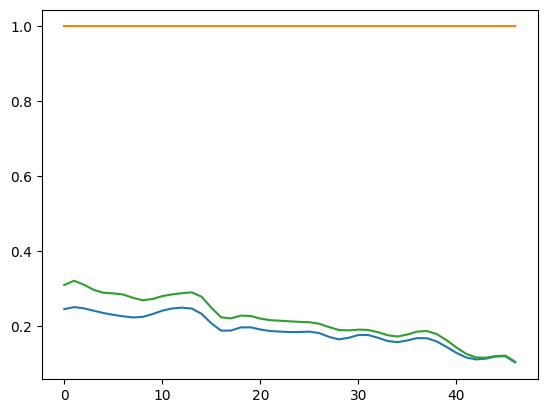

In [40]:
plt.plot(dg_intensity_intp.T)

### Optimized Result

In [131]:
# bring optimized parameters
# opt_param_final = np.load('./opt_params/opt_param_1021_detach_08500.npy')
opt_param_final = np.load('./opt_params/opt_param_dg_detach_%05d.npy'%9500)

# detach
ref_CC_detach = ref_CC.detach().cpu().numpy()
patches_rgb_real_detach = patches_rgb_real
peak_illum_idx_final_detach = real_img_illum_idx

# update parameter
CRF_intp_update = CRF_intp.T * opt_param_final[:,3:]
PEF_intp_update = PEF_intp.T * opt_param_final[:,:3]

# update parameter with dg
CRF_intp_update = CRF_intp.T * opt_param_final[:,3:-2]
PEF_intp_update = PEF_intp.T * opt_param_final[:,:3]
dg_intensity_pfirst_update = torch.sigmoid(dg_intensity[:,2] * opt_param[:,-1]) * 1/2
dg_intensity_mfirst_update = torch.sigmoid(dg_intensity[:,0] * opt_param[:,-2]) * 1/2

In [132]:
# plt.ylim([0,1])
# plt.plot(dg_intensity_mfirst_update.detach().cpu().numpy())

dg_intensity_mfirst_update = dg_intensity_mfirst_update.detach().cpu().numpy()
dg_intensity_pfirst_update = dg_intensity_pfirst_update.detach().cpu().numpy()

In [152]:
dg_zero = np.ones_like(dg_intensity_pfirst_update)

In [153]:
dg = np.stack((dg_intensity_mfirst_update, dg_zero, dg_intensity_pfirst_update))

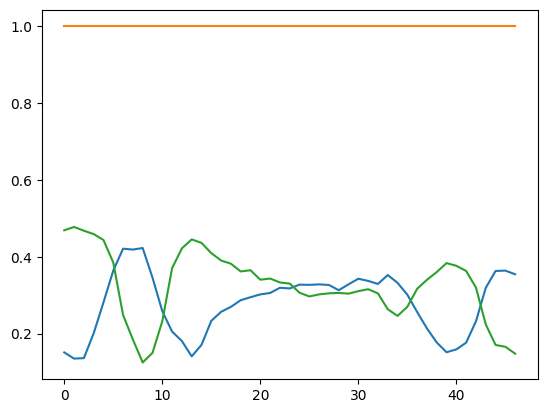

In [154]:
plt.plot(dg.T)

(<AxesSubplot:>, (0.0, 1.0), [<matplotlib.lines.Line2D at 0x20d85459888>])

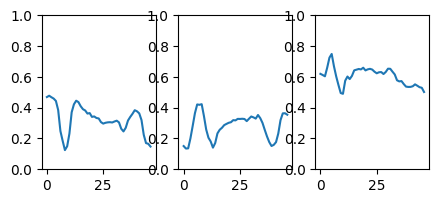

In [145]:
plt.figure(figsize=(5,2))
plt.subplot(131),plt.ylim([0,1]),plt.plot(dg_intensity_pfirst_update)
plt.subplot(132),plt.ylim([0,1]),plt.plot(dg_intensity_mfirst_update)
plt.subplot(133),plt.ylim([0,1]),plt.plot(dg_intensity_pfirst_update + dg_intensity_mfirst_update)

In [133]:
dg_intensity_pfirst_update.shape

(47,)

In [155]:
np.save('./CRF_update_1113.npy', CRF_intp_update)
np.save('./PEF_update_1113.npy', PEF_intp_update)
np.save('./DG_update_1113.npy', dg)

In [134]:
# white pattern
white_patt = np.ones(shape = (1, 3))
white_patt_hyp = white_patt @  PEF_intp_update.T
white_patt_hyp = white_patt_hyp.squeeze()

In [135]:
# # test with GT reflectance for all patches
# total_patch_update = []
# for p in range(n_patches):
#     I_C = ref_CC_detach[:,p][:,np.newaxis] * CRF_intp_update * white_patt_hyp[:,np.newaxis] * DG_efficiency_image[:,p][:,np.newaxis] / depth_scalar[p]

#     total_patch_update.append(I_C)
# total_patch_update = np.array(total_patch_update)

# test with GT reflectance for all patches with dg
total_patch_update = []
for p in range(n_patches):
    if p in pfirst_patches:
        I_C = ref_CC_detach[:,p][:,np.newaxis] * CRF_intp_update * white_patt_hyp[:,np.newaxis] * dg_intensity_pfirst_update[:,np.newaxis] / depth_scalar[p]
    else:
        I_C = ref_CC_detach[:,p][:,np.newaxis] * CRF_intp_update * white_patt_hyp[:,np.newaxis] * dg_intensity_mfirst_update[:,np.newaxis] / depth_scalar[p]
    total_patch_update.append(I_C)
total_patch_update = np.array(total_patch_update)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


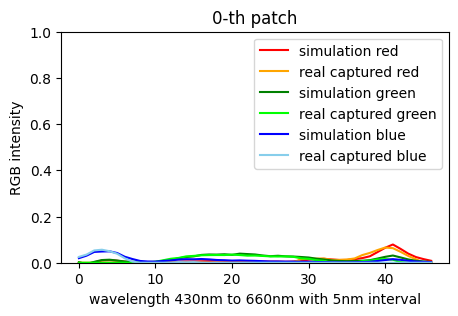

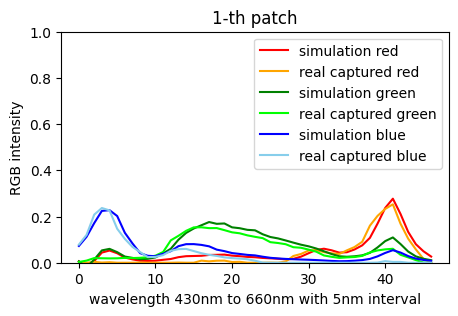

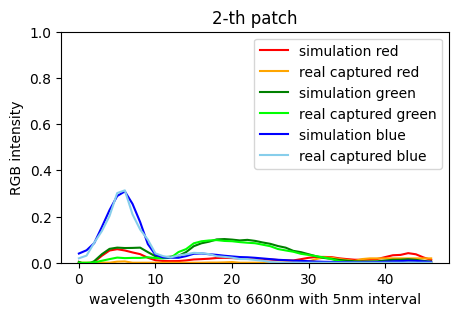

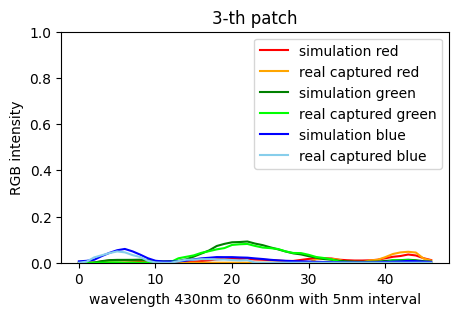

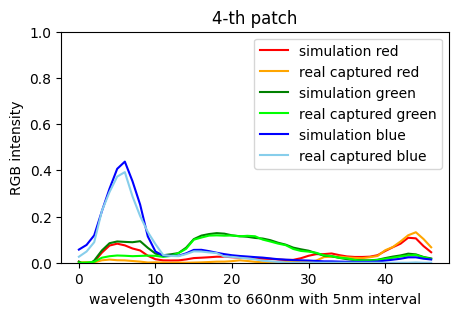

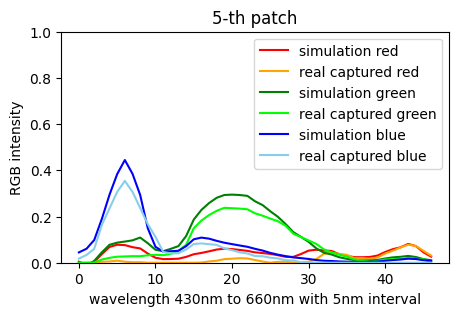

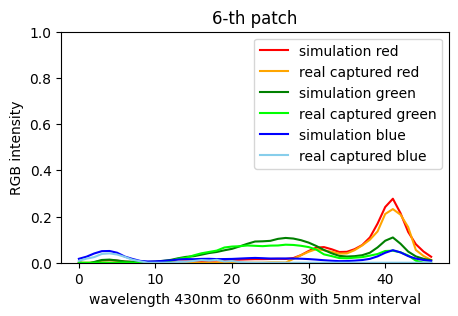

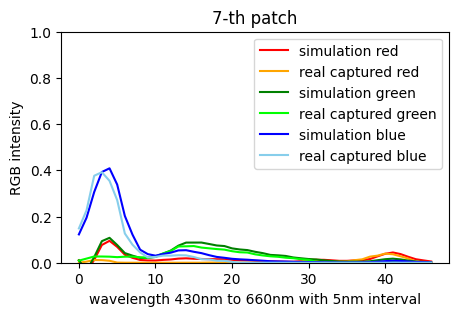

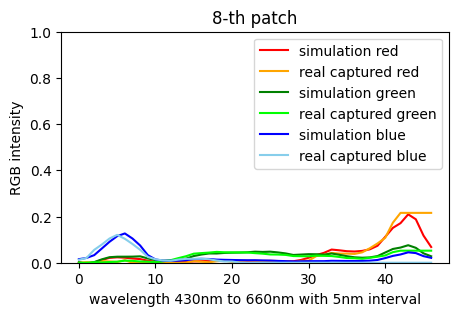

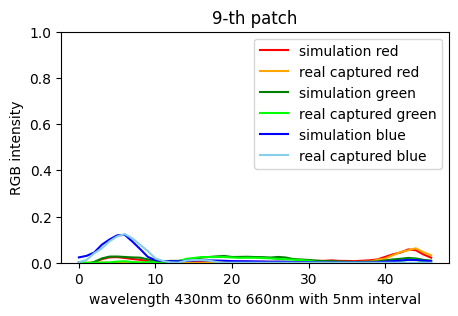

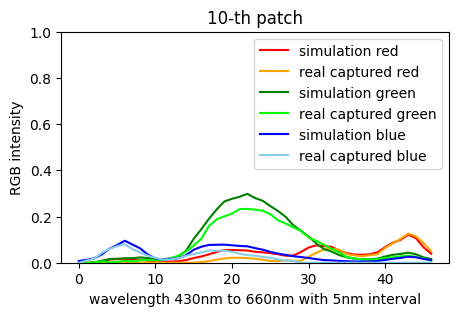

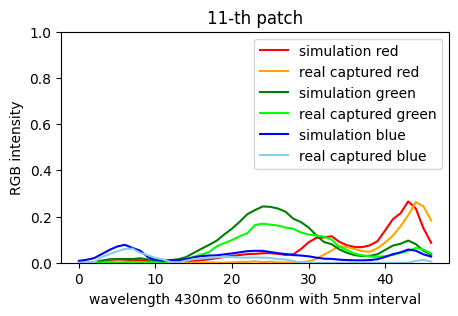

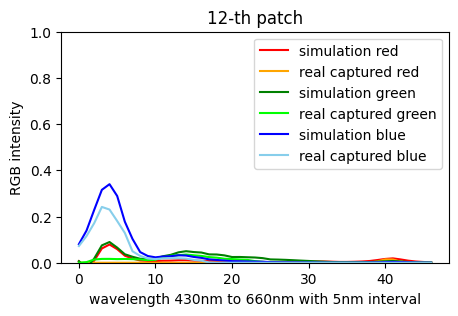

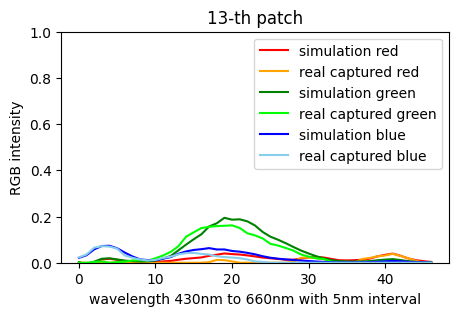

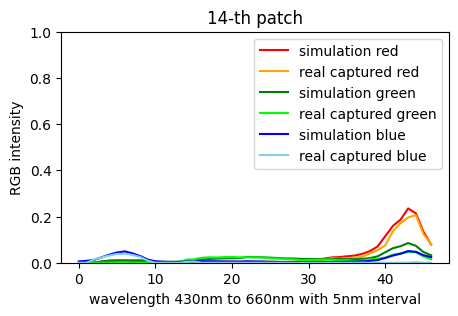

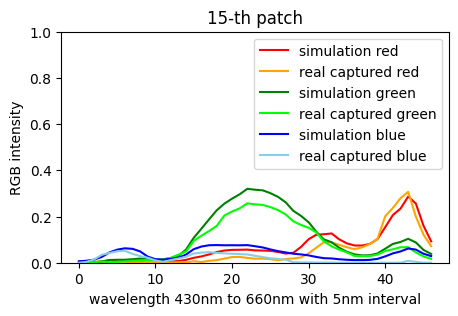

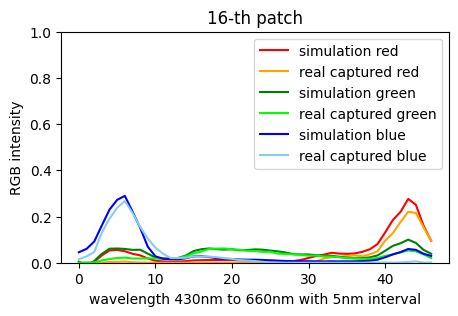

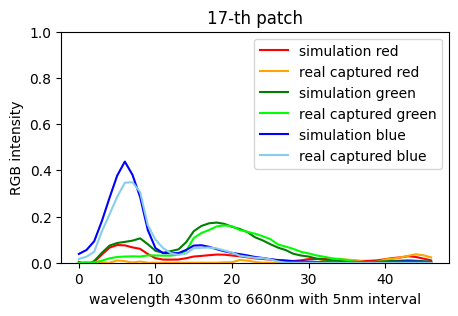

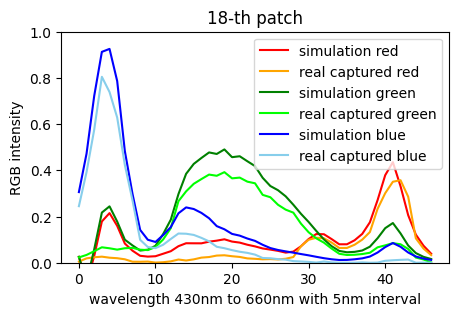

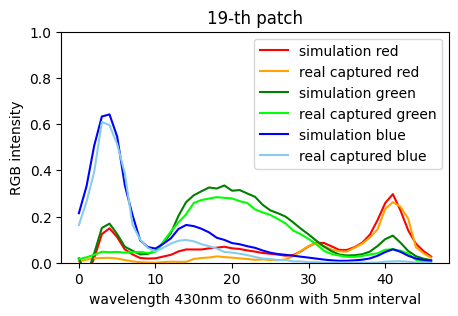

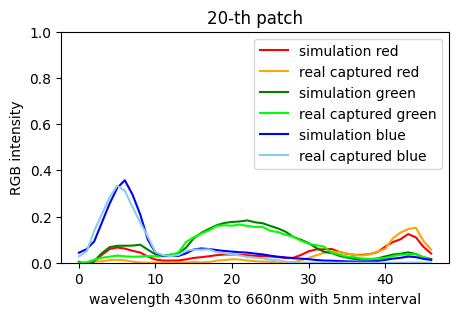

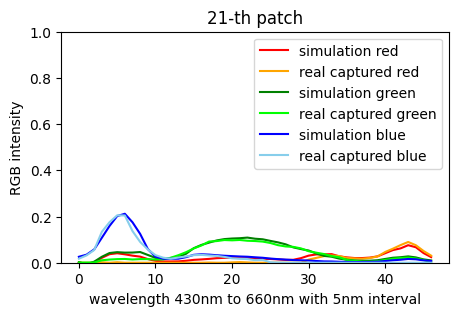

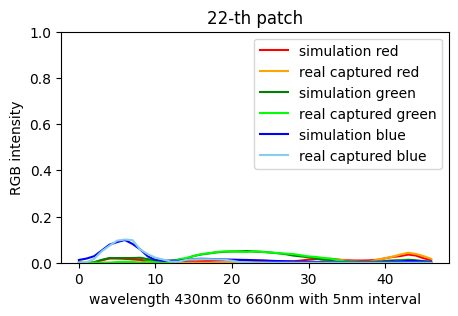

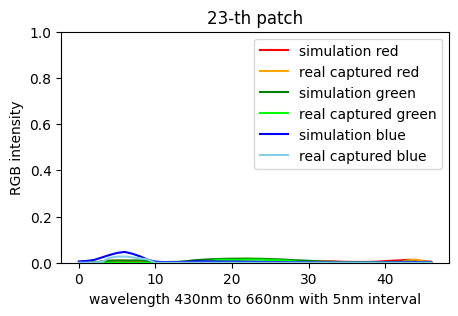

In [136]:
constant = 1
max_ylim = 0.9
patch_num = 1

# plot 1st order rgb intensity for all patches
for p in range(0, 24): # only visualize white patch
    plt.figure(figsize=(5,3))
    plt.ylim([0, 1])    

    # red
    plt.plot(total_patch_update[p][:,0] * constant, c = 'red', label = 'simulation red')
    plt.plot(patches_rgb_real[real_img_illum_idx[:,p], p][:,0], c = 'orange', label = 'real captured red')
    plt.legend()

    # green
    plt.plot(total_patch_update[p][:,1]* constant, c = 'green', label = 'simulation green')
    plt.plot(patches_rgb_real[real_img_illum_idx[:,p], p][:,1], c = 'lime', label = 'real captured green')
    plt.legend()
    
    # blue
    plt.plot(total_patch_update[p][:,2]* constant, c = 'blue', label = 'simulation blue')
    plt.plot(patches_rgb_real[real_img_illum_idx[:,p], p][:,2], c = 'skyblue', label = 'real captured blue')
    
    plt.xlabel('wavelength 430nm to 660nm with 5nm interval')
    plt.ylabel('RGB intensity')
    plt.title('%s-th patch'%p)
    plt.legend()